In [217]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [159]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [160]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]


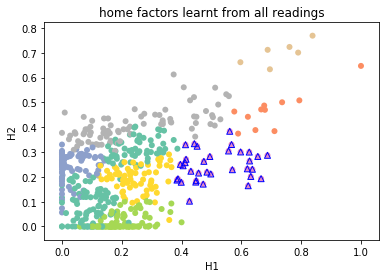

In [161]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")

target_cluster_id = 4
target_cluster_idx = [i for i, j in enumerate(cluster) if j == target_cluster_id]

ax.scatter(X[target_cluster_idx, x1], X[target_cluster_idx, x2], color='blue', marker='^', facecolors='none')



In [162]:
import random
random.seed(10)
random.shuffle(target_cluster_idx)
test_idx = target_cluster_idx[:6]
validate_idx = target_cluster_idx[6:12]

test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [163]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_ix = df.index[validate_idx]


idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [166]:
print test_ix
print validate_ix

Int64Index([8589, 499, 2365, 1202, 9295, 9939], dtype='int64')
Int64Index([7117, 6412, 5568, 7951, 4135, 484], dtype='int64')


In [206]:
from sklearn.metrics.pairwise import cosine_similarity

num_home_factor = 3
num_season_factor = 3

num_test = len(test_ix)
num_validate = len(validate_ix)
num_train = len(train_ix)

num_iterations = 10

train_df = df.loc[train_ix]
test_validate_df = df.loc[np.r_[test_ix, validate_ix]]

train_tensor = get_tensor(train_df, 1, 13)
test_validate_tensor = get_tensor(test_validate_df, 1, 13)

L_train = L[np.ix_(train_idx, train_idx)]
L_test_validate = L[np.ix_(test_validate_idx, test_validate_idx)]

ttv_df = df.loc[np.r_[train_ix, test_ix, validate_ix]]
ttv_tensor = get_tensor(ttv_df, 1, 13)

ttv_idx = np.r_[train_idx, test_idx, validate_idx]
L_ttv = L[np.ix_(ttv_idx, ttv_idx)]

weight_matrices = {}
train_weight = np.ones(train_tensor.shape)

H = {}
A = {}
T = {}

for method in ['independent', 'jointly']:
    H[method] = {}
    A[method] = {}
    T[method] = {}
    weight_matrices[method] = {}

choose = "max"

pred = {}
pred_validation = {}
for method in ['independent', 'jointly']:
    pred[method] = {}
    pred_validation[method] = {}
    for iterations in range(num_iterations):
        pred[method][iterations] = {}
        pred_validation[method][iterations] = {}
        for appliance in APPLIANCES_ORDER:
            pred[method][iterations][appliance] = []
            pred_validation[method][iterations][appliance] = []

tv_weight = np.ones(test_validate_tensor.shape)
print tv_weight.shape

(12, 7, 12)


In [207]:
# independently
method = 'independent'
train_weight = np.ones(train_tensor.shape)

for iteration in range(num_iterations):
    print "iteration: ", iteration
    
    weight_matrices[method][iteration] = train_weight
    tensor_copy = train_tensor.copy()

    # do tensor factorization
    H_train, A_train, T_train, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               L_train,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             train_weight,
                                                              num_iter=3000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)

    # use A, T to learn Home factors of validate and test homes
    tensor_copy = test_validate_tensor.copy()
    tensor_copy[:num_test, 1:, :] = np.NaN
    print tensor_copy.shape
    
    
    H_tv, A_tv, T_tv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L_test_validate,
                                                                       num_home_factor, num_season_factor, tv_weight,
                                                                       num_iter=3000, lr=0.1, dis=True, lam=0,
                                                                       A_known=A_train, T_known=T_train)
    
    HAT = multiply_case(H_tv, A_tv, T_tv, 2)
    for appliance in APPLIANCES_ORDER:
        pred[method][iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
        pred_validation[method][iteration][appliance].append(pd.DataFrame(HAT[num_test:, appliance_index[appliance], :], index = validate_ix))
                
    # use the Home factors to update the weight matrix
    H_validate = H_tv[num_test:]
    
    H_validate_train = np.r_[H_validate, H_train]
    similarities = cosine_similarity(H_validate_train)
    sim = similarities[num_validate:, :num_validate]
    ####
    sim = sim.max(axis=1)
    sim = (sim - sim.min())/(sim.max() - sim.min())
#     sim[200:] = 0
    ####
    # print len
    train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    print train_weight.shape
    
    # store the home factors
    H[method][iteration] = np.r_[H_tv, H_train]
    A[method][iteration] = A_train
    T[method][iteration] = T_train

iteration:  0
496.186979347
137.901043324
97.8573053169
92.3670788774
86.7920163102
82.7346100716
(12, 7, 12)
614.09580259
144.183529294
106.988126524
102.159382287
99.6792713729
98.0047265446
(521, 7, 12)
iteration:  1
436.726730249
121.185559346
85.2457831571
80.0439378053
75.6431905073
72.8569412675
(12, 7, 12)
610.404657519
130.284091752
101.882602045
98.8008002874
97.2075737286
96.1524827322
(521, 7, 12)
iteration:  2
427.76842953
118.701907521
83.1896798048
78.0784337422
73.9339531023
71.2373337187
(12, 7, 12)
609.513080273
127.303024279
100.7183688
97.9453743167
96.5347571741
95.6138269862
(521, 7, 12)
iteration:  3
435.05620342
120.956261774
84.8142909347
79.6498004406
75.3314872087
72.4877482108
(12, 7, 12)
610.004983082
128.946398227
101.286410725
98.329089821
96.8196520851
95.8300940677
(521, 7, 12)
iteration:  4
434.859546903
120.755278285
84.6964136272
79.5351309969
75.2297363137
72.4516957476
(12, 7, 12)
609.990505503
129.047417194
101.436653351
98.4613415167
96.933275398

In [208]:
# jointly
method = 'jointly'
train_weight = np.ones(train_tensor.shape)

for iteration in range(num_iterations):
    print "iteration: ", iteration
    
    weight = np.r_[train_weight, tv_weight]
    
    weight_matrices[method][iteration] = weight
    tensor_copy = ttv_tensor.copy()
    tensor_copy[num_train:(num_train + num_test), 1: , :] = np.NaN

    # do tensor factorization
    H_ttv, A_ttv, T_ttv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               L_ttv,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             weight, num_iter=3000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)

    
    HAT = multiply_case(H_ttv, A_ttv, T_ttv, 2)
    for appliance in APPLIANCES_ORDER:
        pred[method][iteration][appliance].append(pd.DataFrame(HAT[num_train:(num_train + num_test), appliance_index[appliance], :], index = test_ix))
        pred_validation[method][iteration][appliance].append(pd.DataFrame(HAT[(num_train + num_test):, appliance_index[appliance], :], index = validate_ix))
                
    # use the Home factors to update the weight matrix
    
    similarities = cosine_similarity(H_ttv)
    sim = similarities[:num_train, (num_train + num_test):]
    ####
    sim = sim.max(axis=1)
    sim = (sim - sim.min())/(sim.max() - sim.min())
#     sim[200:] = 0
    ####
    # print len
    train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
#     print train_weight.shape
    
    # store the home factors
    H[method][iteration] = H_ttv
    A[method][iteration] = A_ttv
    T[method][iteration] = T_ttv

iteration:  0
500.484029263
140.600136553
101.474417731
89.158481481
83.344060479
80.1053938221
iteration:  1
426.478274875
118.651802088
85.7663398962
75.7573985091
71.7256918442
69.4394894954
iteration:  2
416.521027918
115.92871302
83.4584697854
73.9650079336
70.2257124719
68.0755556354
iteration:  3
423.438699712
118.004772654
84.954528686
75.1323369316
71.2964442744
69.0980959968
iteration:  4
419.854577411
117.108839214
84.3177177123
74.5849194045
70.78655642
68.5924546808
iteration:  5
423.858960104
118.257699957
85.1293631491
75.2214403476
71.3729709365
69.1492530426
iteration:  6
419.787665002
117.075252033
84.2861828519
74.5656105751
70.77061962
68.579852676
iteration:  7
423.90114646
118.299688929
85.1630917531
75.2378910474
71.3901275382
69.1625990886
iteration:  8
419.729058288
117.059780081
84.2744113562
74.5568945722
70.7628527359
68.5725301917
iteration:  9
423.927580172
118.319973175
85.1781260124
75.2460335051
71.3990070472
69.1702994182


### Home factors and weights

ValueError: Invalid RGBA argument: 1.0

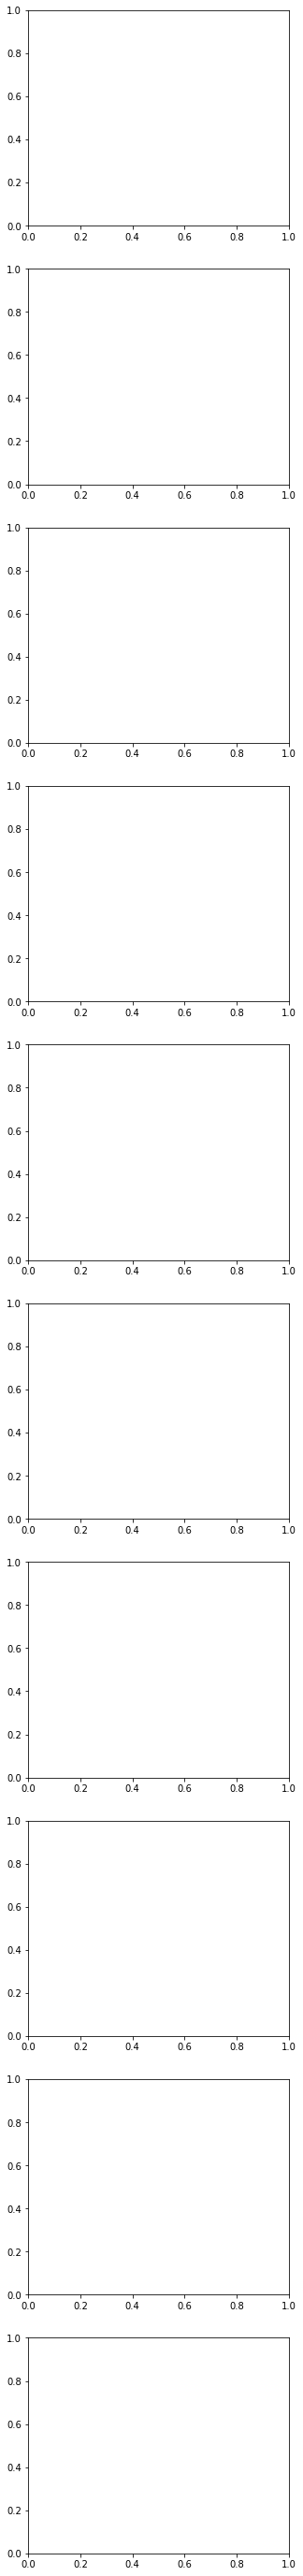

In [189]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

choice = 'max'
for iteration in range(0, num_iterations, 2):
    X = H[method][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
   
    
    train_sim = weight_matrices[method][iteration][:].mean(axis=1).mean(axis=1)
    axes[iteration/2].scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='red', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    plt.title('iteration {}'.format(iteration))


### test homes

In [209]:
out= {}

for choice in ['independent', 'jointly']:
    out[choice] = {}
    for iteration in range(num_iterations):
        print choice, iteration
        out[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[choice][iteration][appliance]).loc[test_ix]
            print appliance
            try:
                if appliance=="hvac":
                    out[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

independent 0
hvac
fridge
mw
dw
wm
oven
independent 1
hvac
fridge
mw
dw
wm
oven
independent 2
hvac
fridge
mw
dw
wm
oven
independent 3
hvac
fridge
mw
dw
wm
oven
independent 4
hvac
fridge
mw
dw
wm
oven
independent 5
hvac
fridge
mw
dw
wm
oven
independent 6
hvac
fridge
mw
dw
wm
oven
independent 7
hvac
fridge
mw
dw
wm
oven
independent 8
hvac
fridge
mw
dw
wm
oven
independent 9
hvac
fridge
mw
dw
wm
oven
jointly 0
hvac
fridge
mw
dw
wm
oven
jointly 1
hvac
fridge
mw
dw
wm
oven
jointly 2
hvac
fridge
mw
dw
wm
oven
jointly 3
hvac
fridge
mw
dw
wm
oven
jointly 4
hvac
fridge
mw
dw
wm
oven
jointly 5
hvac
fridge
mw
dw
wm
oven
jointly 6
hvac
fridge
mw
dw
wm
oven
jointly 7
hvac
fridge
mw
dw
wm
oven
jointly 8
hvac
fridge
mw
dw
wm
oven
jointly 9
hvac
fridge
mw
dw
wm
oven


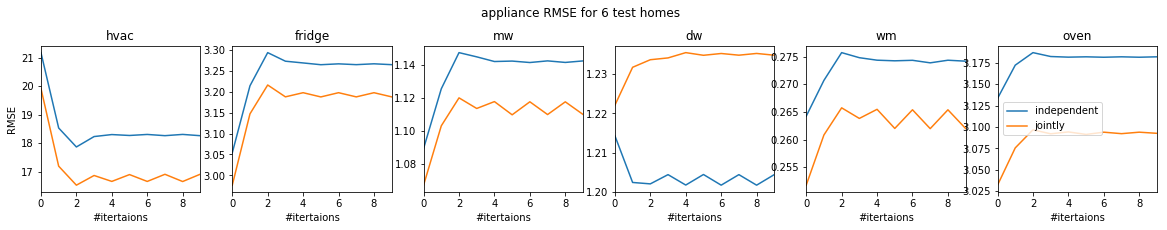

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
mean_out['independent'] = pd.DataFrame(out['independent'])
mean_out['jointly'] = pd.DataFrame(out['jointly'])
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['independent'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['jointly'].T[appliance].plot(ax = ax[count], title=appliance)

#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['independent', 'jointly'], loc='center left')
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test_jointly.pdf", format='pdf')

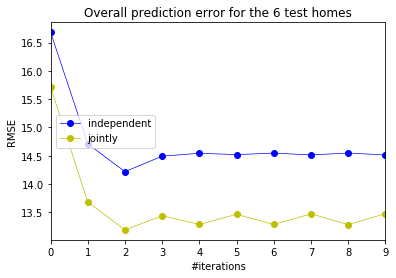

In [219]:
fig, ax = plt.subplots()
error = {}
error['independent'] = (mean_out['independent'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['independent'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

error['jointly'] = (mean_out['jointly'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['jointly'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['independent', 'jointly'], loc='center left')

plt.savefig("overall-RMSE_test_jointly.pdf", format='pdf')

In [220]:
error['jointly']

0    15.714046
1    13.680922
2    13.188317
3    13.440528
4    13.285065
5    13.464387
6    13.284389
7    13.472272
8    13.281992
9    13.475921
dtype: float64

### validation homes

In [138]:
out_v = {}

for choice in ['max']:
    out_v[choice] = {}
    for iteration in range(num_iterations):
        print choice, iteration
        out_v[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_validation[iteration][appliance]).loc[validate_ix]
            print appliance
            try:
                if appliance=="hvac":
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

max 0
hvac
fridge
mw
dw
wm
oven
max 1
hvac
fridge
mw
dw
wm
oven
max 2
hvac
fridge
mw
dw
wm
oven
max 3
hvac
fridge
mw
dw
wm
oven
max 4
hvac
fridge
mw
dw
wm
oven
max 5
hvac
fridge
mw
dw
wm
oven
max 6
hvac
fridge
mw
dw
wm
oven
max 7
hvac
fridge
mw
dw
wm
oven
max 8
hvac
fridge
mw
dw
wm
oven
max 9
hvac
fridge
mw
dw
wm
oven
max 10
hvac
fridge
mw
dw
wm
oven
max 11
hvac
fridge
mw
dw
wm
oven
max 12
hvac
fridge
mw
dw
wm
oven
max 13
hvac
fridge
mw
dw
wm
oven
max 14
hvac
fridge
mw
dw
wm
oven
max 15
hvac
fridge
mw
dw
wm
oven
max 16
hvac
fridge
mw
dw
wm
oven
max 17
hvac
fridge
mw
dw
wm
oven
max 18
hvac
fridge
mw
dw
wm
oven
max 19
hvac
fridge
mw
dw
wm
oven


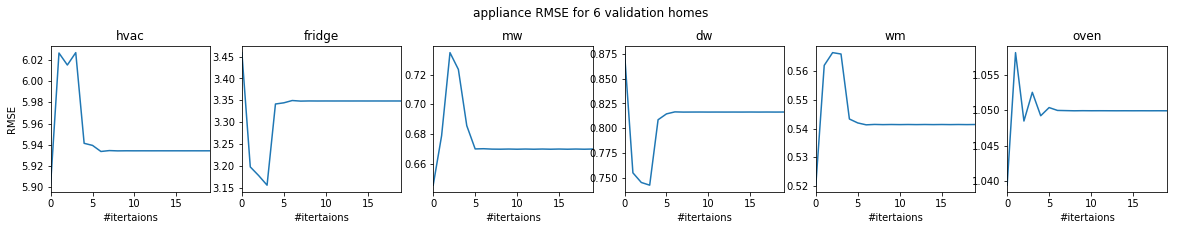

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out_v = pd.DataFrame(out_v['max'])
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out_v.T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['same cluster', 'different cluster'], loc='center left')
plt.suptitle("appliance RMSE for 6 validation homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-RMSE_test_same_diff.pdf", format='pdf')

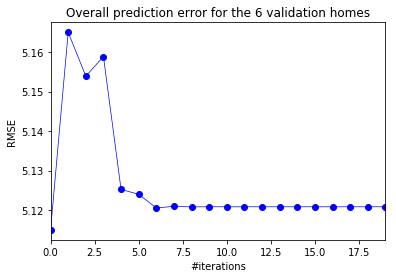

In [149]:
fig, ax = plt.subplots()
error_v = {}
error_v = (mean_out_v.T*pd.Series(contri['Austin'])).sum(axis=1)
error_v.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 validation homes")
# plt.savefig("overall-RMSE_validate.pdf", format='pdf')

In [112]:
out_v = {}
for tv_type in ['same', 'diff']:
    out_v[tv_type] = {}
    for choice in ['max', 'min']:
        out_v[tv_type][choice] = {}
        for iteration in range(num_iterations):
            print tv_type, choice, iteration
            out_v[tv_type][choice][iteration] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                if tv_type == 'same':
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                else: 
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                if appliance=="hvac":
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

same max 0
same max 1
same max 2
same max 3
same max 4
same max 5
same max 6
same max 7
same max 8
same max 9
same max 10
same max 11
same max 12
same max 13
same max 14
same max 15
same max 16
same max 17
same max 18
same max 19
same min 0
same min 1
same min 2
same min 3
same min 4
same min 5
same min 6
same min 7
same min 8
same min 9
same min 10
same min 11
same min 12
same min 13
same min 14
same min 15
same min 16
same min 17
same min 18
same min 19
diff max 0
diff max 1
diff max 2
diff max 3
diff max 4
diff max 5
diff max 6
diff max 7
diff max 8
diff max 9
diff max 10
diff max 11
diff max 12
diff max 13
diff max 14
diff max 15
diff max 16
diff max 17
diff max 18
diff max 19
diff min 0
diff min 1
diff min 2
diff min 3
diff min 4
diff min 5
diff min 6
diff min 7
diff min 8
diff min 9
diff min 10
diff min 11
diff min 12
diff min 13
diff min 14
diff min 15
diff min 16
diff min 17
diff min 18
diff min 19


KeyError: 'min'

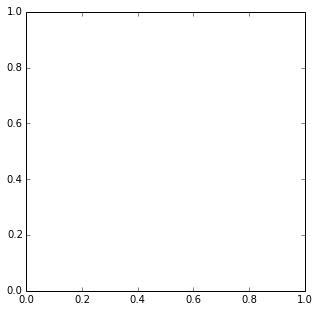

In [117]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 50))
fig, ax = plt.subplots(figsize=(5,5))
choice = "min"
for iteration in [6]:
    X = H[choice][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
#     x1 = 2
#     x2 = 0
    
    train_sim = weight_matrices[choice][iteration][:].mean(axis=1).mean(axis=1)
    ax.scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    ax.scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    ax.scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    ax.set_title("iteration {}". format(iteration))
    
    plt.savefig("weight_iteration_6_{}.pdf".format(choice), format='pdf')
#     axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

### test homes

In [49]:
out = {}
for choice in ['max', 'min']:
    out[choice] = {}
    for iteration in range(num_iterations):
        out[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[choice][iteration][appliance]).loc[test_ix]
            if appliance=="hvac":
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

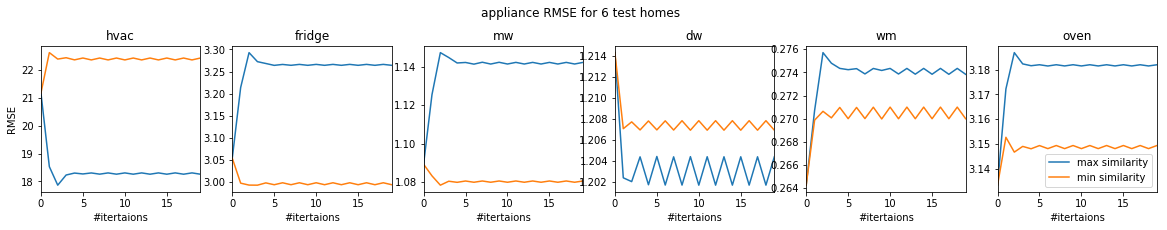

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
mean_out['min'] = pd.DataFrame(out['min'])
mean_out['max'] = pd.DataFrame(out['max'])

for appliance in APPLIANCES_ORDER[1:]:
    mean_out['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['min'].T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['max similarity', 'min similarity'])
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test.pdf", format='pdf')

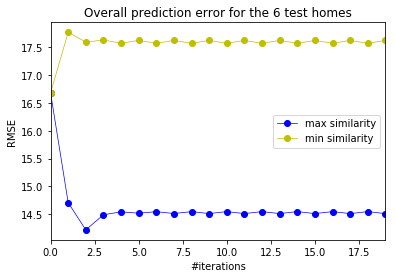

In [102]:
fig, ax = plt.subplots()
error['max'] = (mean_out['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error['min'] = (mean_out['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_test.pdf", format='pdf')

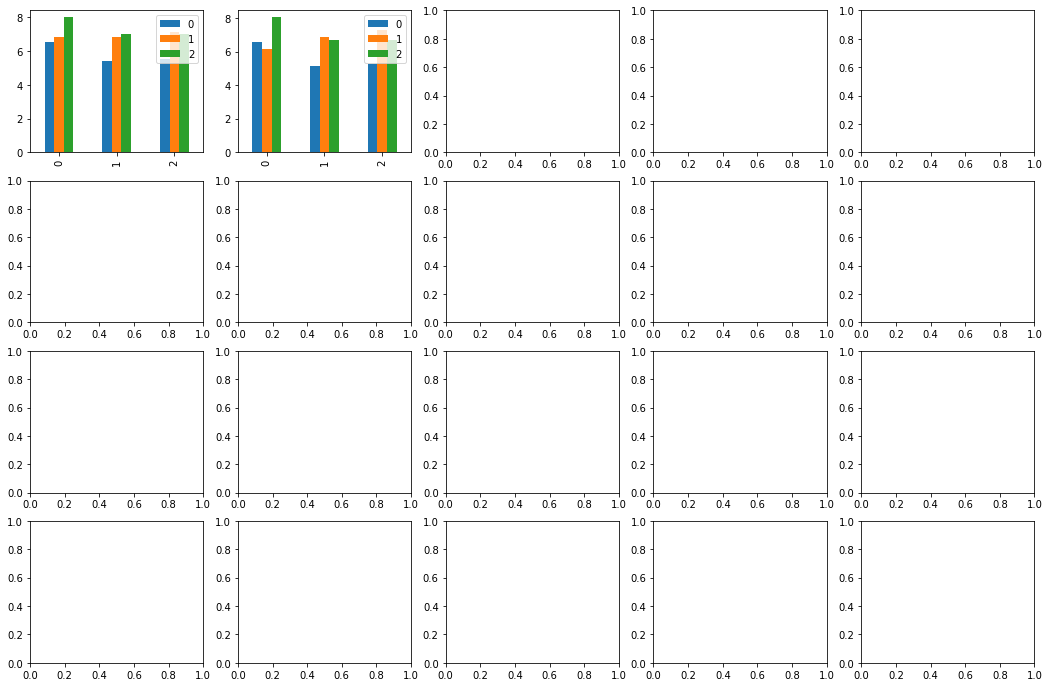

In [101]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))


pd.DataFrame(A['max'][2][0]).plot(ax=axes[0][0], kind='bar')
pd.DataFrame(A['min'][2][0]).plot(ax=axes[0][1], kind='bar')


In [26]:
for iteration in [1]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
#     print sim_df
    for i in set(cluster):
        print i
        sub_cluster = sim_df.loc[sim_df[0] == i]
#         print sub_cluster[1]
        print sub_cluster[1].mean(axis=0)
    

0
0.720437494274
1
0.0135169107494
2
0.85064710518
3
0.782826517102
4
0.586187154995
5
0.968014577588
6
0.824718495544
7
0.919507619139
8
0.529737241121
9
0.349787779521


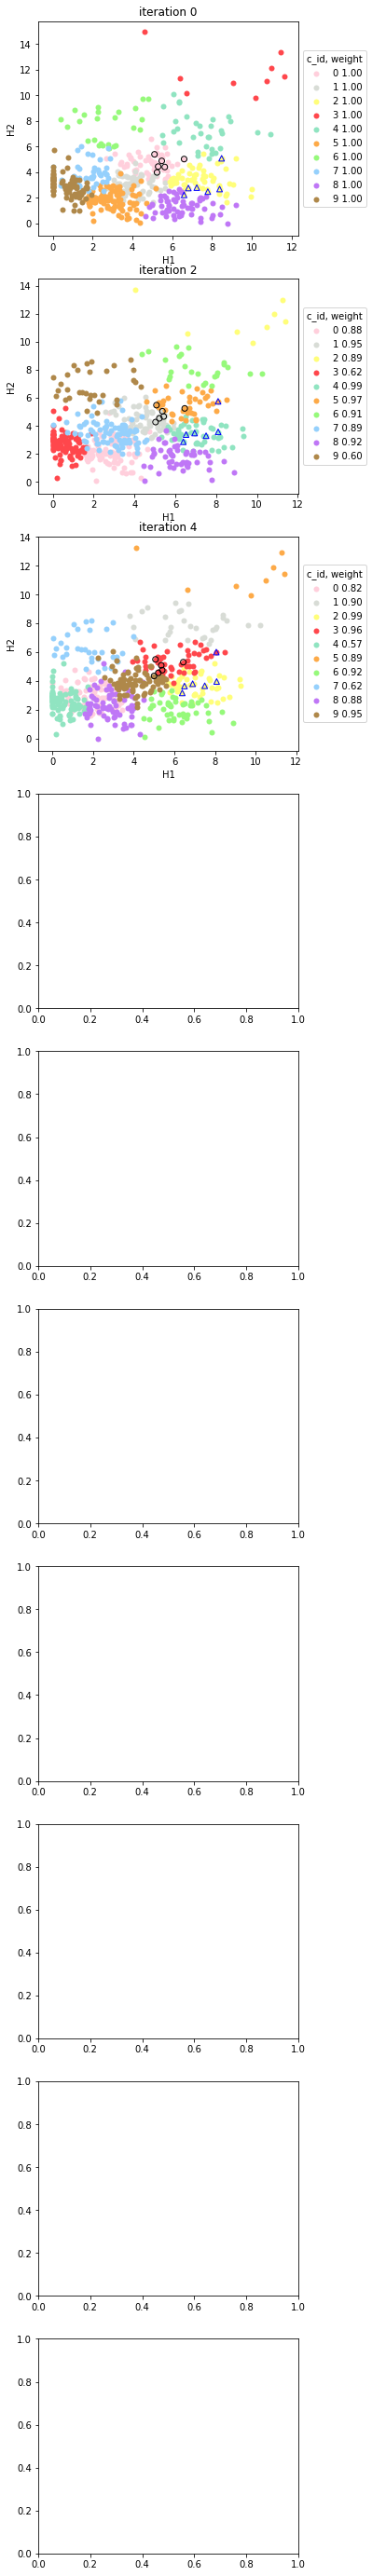

In [127]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

colors = ['#ffcfdc', '#d8dcd6', '#fffe7a', '#ff474c', '#90e4c1', '#fdaa48', '#96f97b', '#95d0fc', '#bf77f6', '#af884a']
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
    
    for c_id in set(cluster):
        
        sub_cluster = sim_df.loc[sim_df[0] == c_id]
        mean_sim = format(sub_cluster[1].mean(axis=0), '.2f')
        
        index = [i for i,j in enumerate(cluster) if j == c_id]
        train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
        axes[iteration/2].scatter(X[index, x1], X[index, x2], c = colors[c_id], lw=0, label="{} {}".format(c_id, mean_sim))
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='blue', marker='^', facecolors='none')
    axes[iteration/2].set_xlabel("H1")
    axes[iteration/2].set_ylabel("H2")
    axes[iteration/2].set_title("iteration {}". format(iteration))
    axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")